# 오버워치 2 점수판 분석 AI

In [1]:
import pandas as pd
from os import path
import joblib

players = 10


def prepare_scoreboards(defeat_, victory_):
    scoreboards_ = pd.concat([defeat_, victory_])
    scoreboards_.set_index(
        pd.Index((i, j) for i in range(len(scoreboards_.index) // players) for j in range(players)), inplace=True
    )
    return scoreboards_


datapath = path.join('datasets', '')
range_ = range(3, 10)
defeat = pd.read_csv(datapath + 'defeat.csv', usecols=range_)
victory = pd.read_csv(datapath + 'victory.csv', usecols=range_)
scoreboards = prepare_scoreboards(defeat, victory)
d_max = scoreboards['D'].max()
joblib.dump(d_max, 'max.joblib')
scoreboards.loc[
    (
            scoreboards['E'] == 0
    ) & (
            scoreboards['A'] == 0
    ) & (
            scoreboards['D'] == 0
    ) & (
            scoreboards['DMG'] == 0
    ) & (
            scoreboards['H'] == 0
    ) & (
            scoreboards['MIT'] == 0
    ), 'D'
] = d_max
scoreboards

E   A   D   DMG     H   MIT     GAME
0   0   7   3   6  5933  1068  6199   DEFEAT
    1   7   0  10  3601   747     0   DEFEAT
    2   9   1   6  4352     0     0   DEFEAT
    3   7   7   2  2332  6325     0   DEFEAT
    4   6   4   2  3410  5979   606   DEFEAT
...    ..  ..  ..   ...   ...   ...      ...
517 5   7   0   9  3772    81  5351  VICTORY
    6  14   5   8  4734     0     0  VICTORY
    7  10   0  11  5035   151   206  VICTORY
    8   6  11   7   619  5174   476  VICTORY
    9  10   0   6  4601  2056     0  VICTORY

[5180 rows x 7 columns]

In [2]:
scoreboards.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5180 entries, (0, 0) to (517, 9)
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   E       5180 non-null   int64 
 1   A       5180 non-null   int64 
 2   D       5180 non-null   int64 
 3   DMG     5180 non-null   int64 
 4   H       5180 non-null   int64 
 5   MIT     5180 non-null   int64 
 6   GAME    5180 non-null   object
dtypes: int64(6), object(1)
memory usage: 319.1+ KB


In [3]:
scoreboards.describe()

,E,A,D,DMG,H,MIT
count,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000
mean,13.772973,7.237066,6.420656,6202.973938,3831.971236,2395.012162
std,9.528800,8.117201,3.838867,4281.815379,5033.131346,4650.164082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,1.000000,4.000000,2768.750000,0.000000,0.000000
50%,13.000000,4.000000,6.000000,5533.000000,753.000000,368.000000
75%,20.000000,12.000000,9.000000,9067.500000,7415.750000,2003.250000
max,58.000000,54.000000,21.000000,26666.000000,27756.000000,41849.000000


In [4]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
IMAGES_PATH = path.join('.', 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장:' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

In [5]:
scoreboards

E   A   D   DMG     H   MIT     GAME
0   0   7   3   6  5933  1068  6199   DEFEAT
    1   7   0  10  3601   747     0   DEFEAT
    2   9   1   6  4352     0     0   DEFEAT
    3   7   7   2  2332  6325     0   DEFEAT
    4   6   4   2  3410  5979   606   DEFEAT
...    ..  ..  ..   ...   ...   ...      ...
517 5   7   0   9  3772    81  5351  VICTORY
    6  14   5   8  4734     0     0  VICTORY
    7  10   0  11  5035   151   206  VICTORY
    8   6  11   7   619  5174   476  VICTORY
    9  10   0   6  4601  2056     0  VICTORY

[5180 rows x 7 columns]

In [6]:
tank = pd.concat([scoreboards[::players], scoreboards[5::players]])
damage = pd.concat([scoreboards[1::players], scoreboards[2::players], scoreboards[6::players], scoreboards[7::players]])
support = pd.concat(
    [scoreboards[3::players], scoreboards[4::players], scoreboards[8::players], scoreboards[9::players]]
)

In [7]:
tank.describe()

,E,A,D,DMG,H,MIT
count,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000,1036.000000
mean,17.731660,4.240347,6.128378,9073.666023,373.942085,9728.406371
std,10.142816,3.718235,3.687808,4118.594474,1123.378787,6089.394590
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,1.000000,3.000000,6067.250000,0.000000,5447.500000
50%,17.000000,3.000000,6.000000,8863.000000,0.000000,8531.000000
75%,24.000000,6.000000,8.000000,11677.500000,19.500000,12958.750000
max,58.000000,24.000000,21.000000,24682.000000,15168.000000,41849.000000


In [8]:
damage.describe()

,E,A,D,DMG,H,MIT
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000
mean,17.060328,1.893822,7.093629,8176.329151,342.646718,635.247104
std,9.147840,2.575245,4.073790,3640.031318,549.592887,1111.892601
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,4.000000,5533.750000,0.000000,0.000000
50%,16.000000,1.000000,7.000000,7813.500000,3.000000,81.000000
75%,23.000000,3.000000,10.000000,10463.750000,517.000000,819.750000
max,52.000000,18.000000,21.000000,26666.000000,3353.000000,9682.000000


In [9]:
support.describe()

,E,A,D,DMG,H,MIT
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000
mean,8.506274,14.078668,5.893822,2794.272683,9050.310328,488.080116
std,6.749928,8.446445,3.561872,2116.058034,4124.232314,818.094044
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,8.000000,3.000000,1257.500000,6098.500000,0.000000
50%,7.000000,13.000000,6.000000,2465.500000,8601.000000,197.000000
75%,13.000000,19.000000,8.000000,3827.000000,11538.000000,617.000000
max,52.000000,54.000000,21.000000,16254.000000,27756.000000,7778.000000


그림 저장:tank_hist


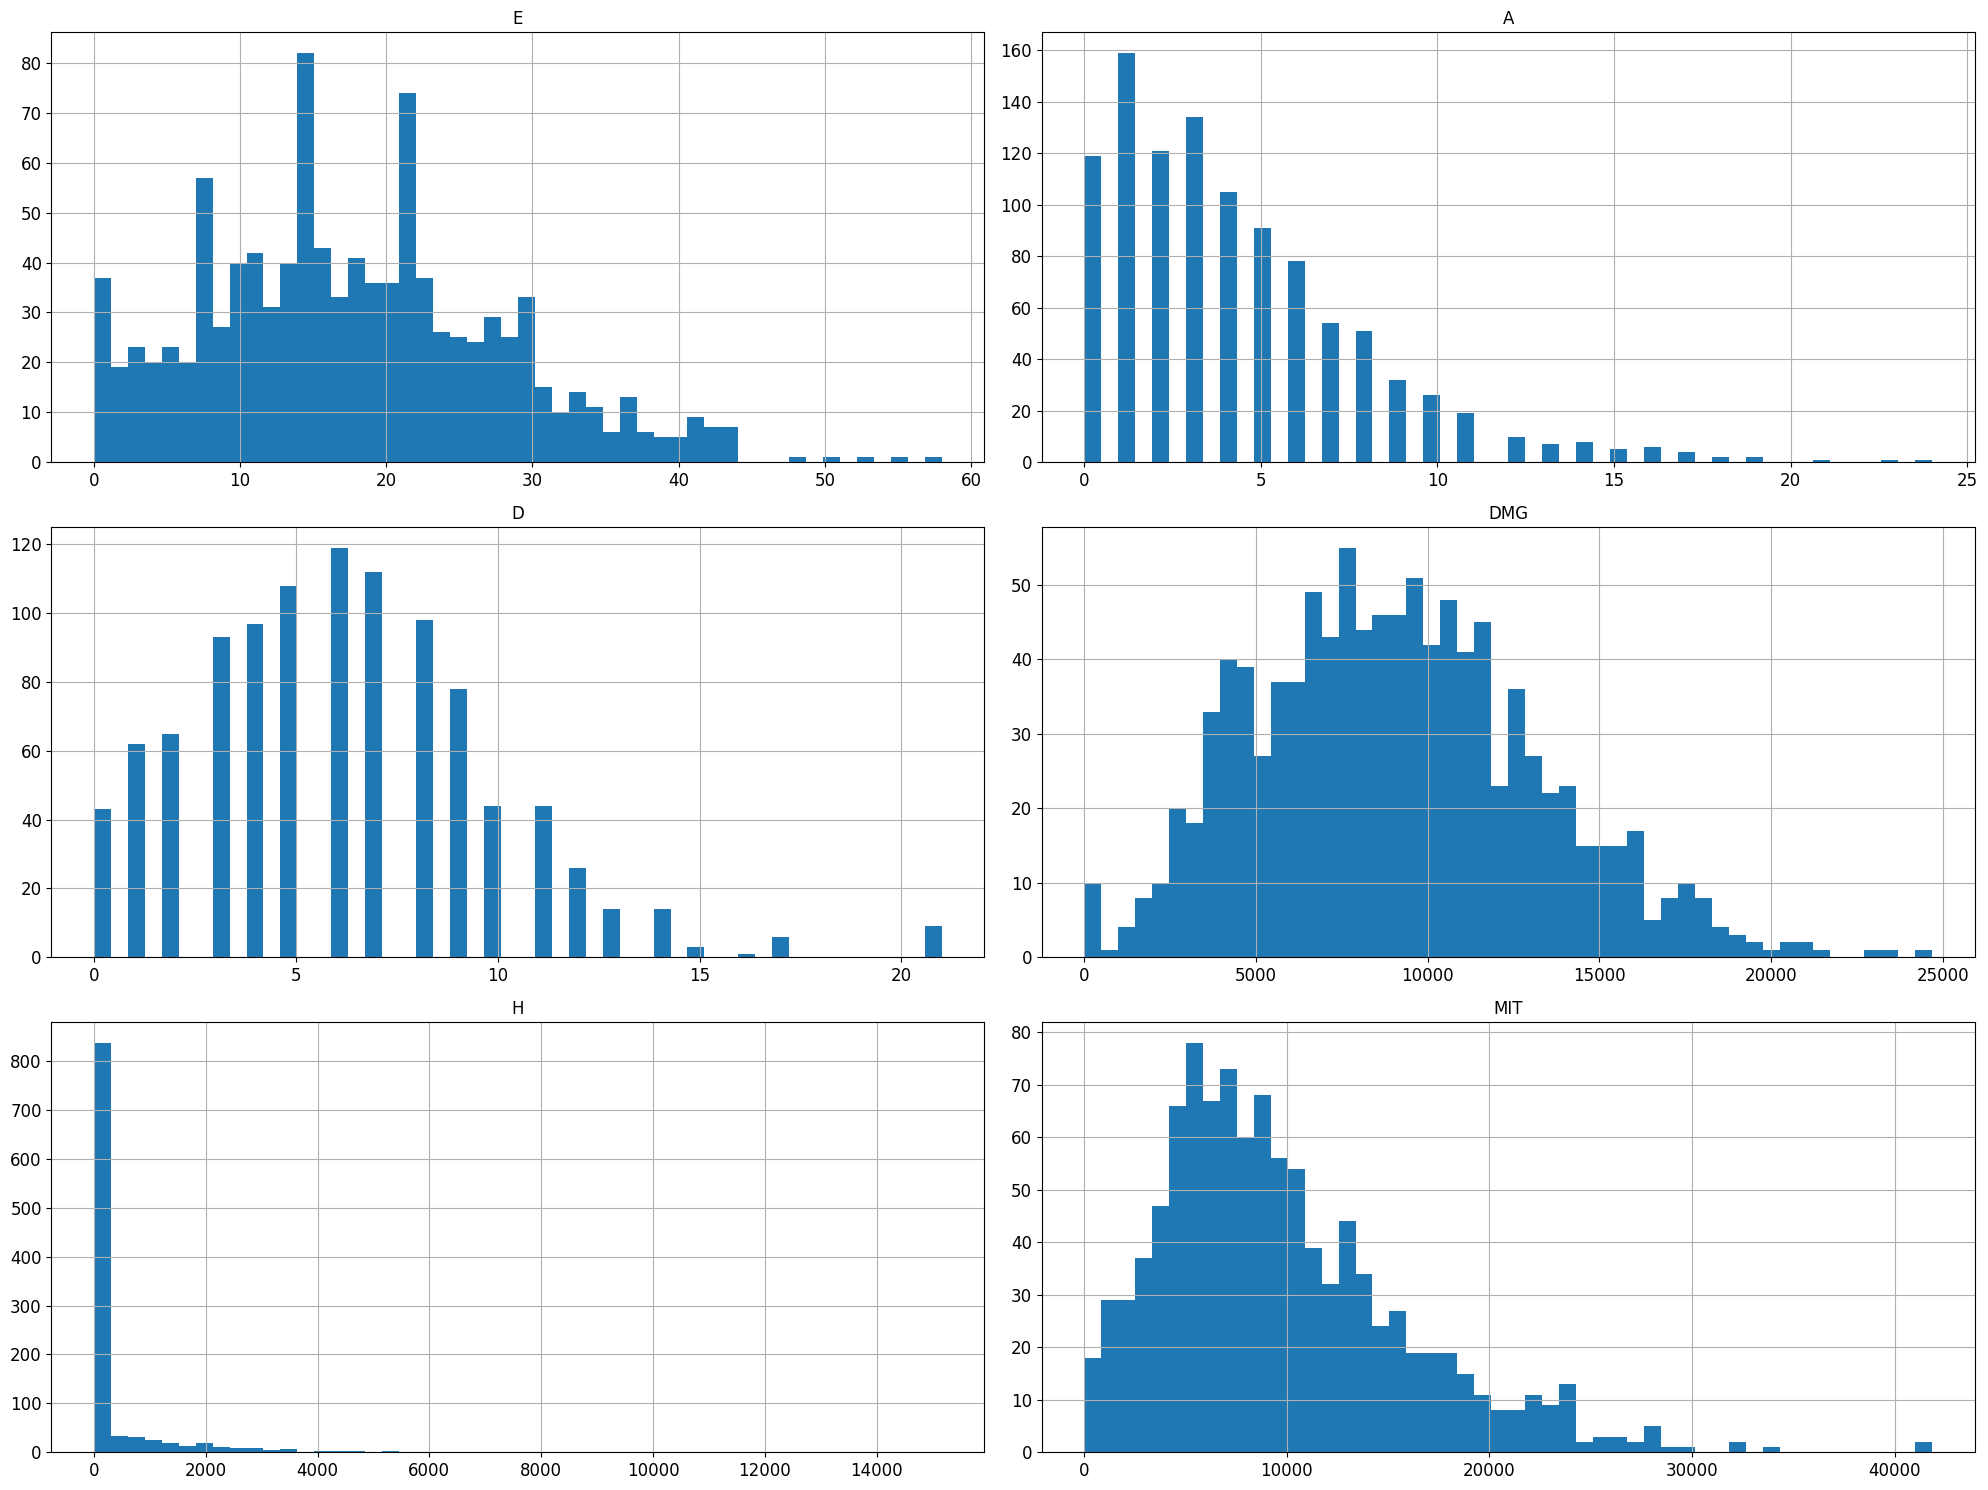

In [10]:
tank.hist(bins=50, figsize=(20, 15))
save_fig('tank_hist')
plt.show()

그림 저장:damage_hist


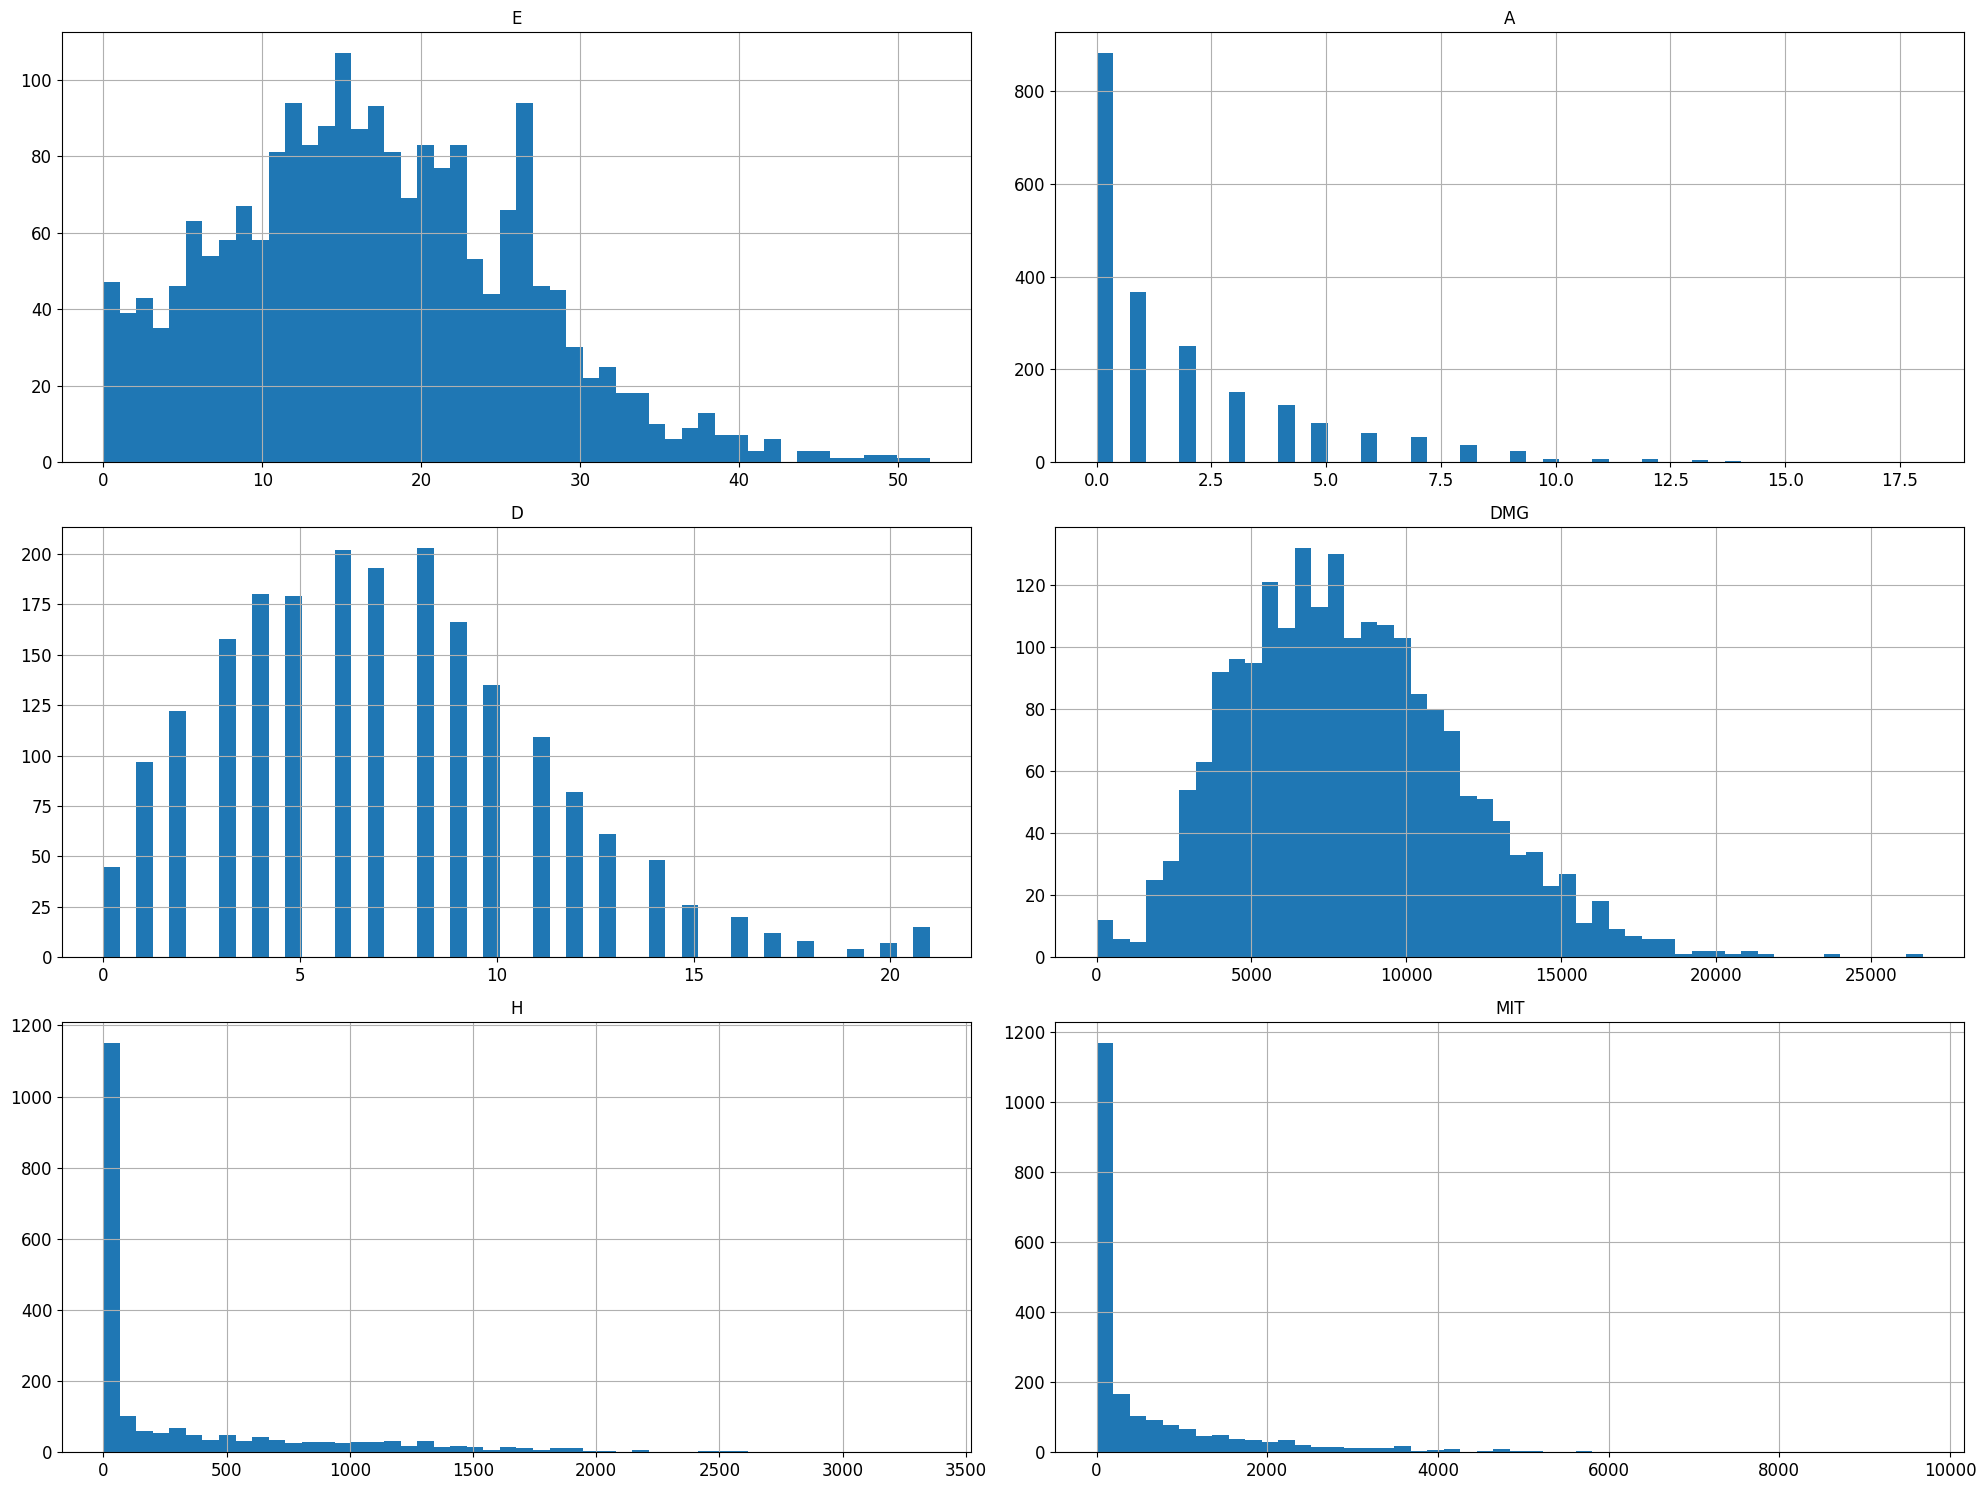

In [11]:
damage.hist(bins=50, figsize=(20, 15))
save_fig('damage_hist')
plt.show()

그림 저장:support_hist


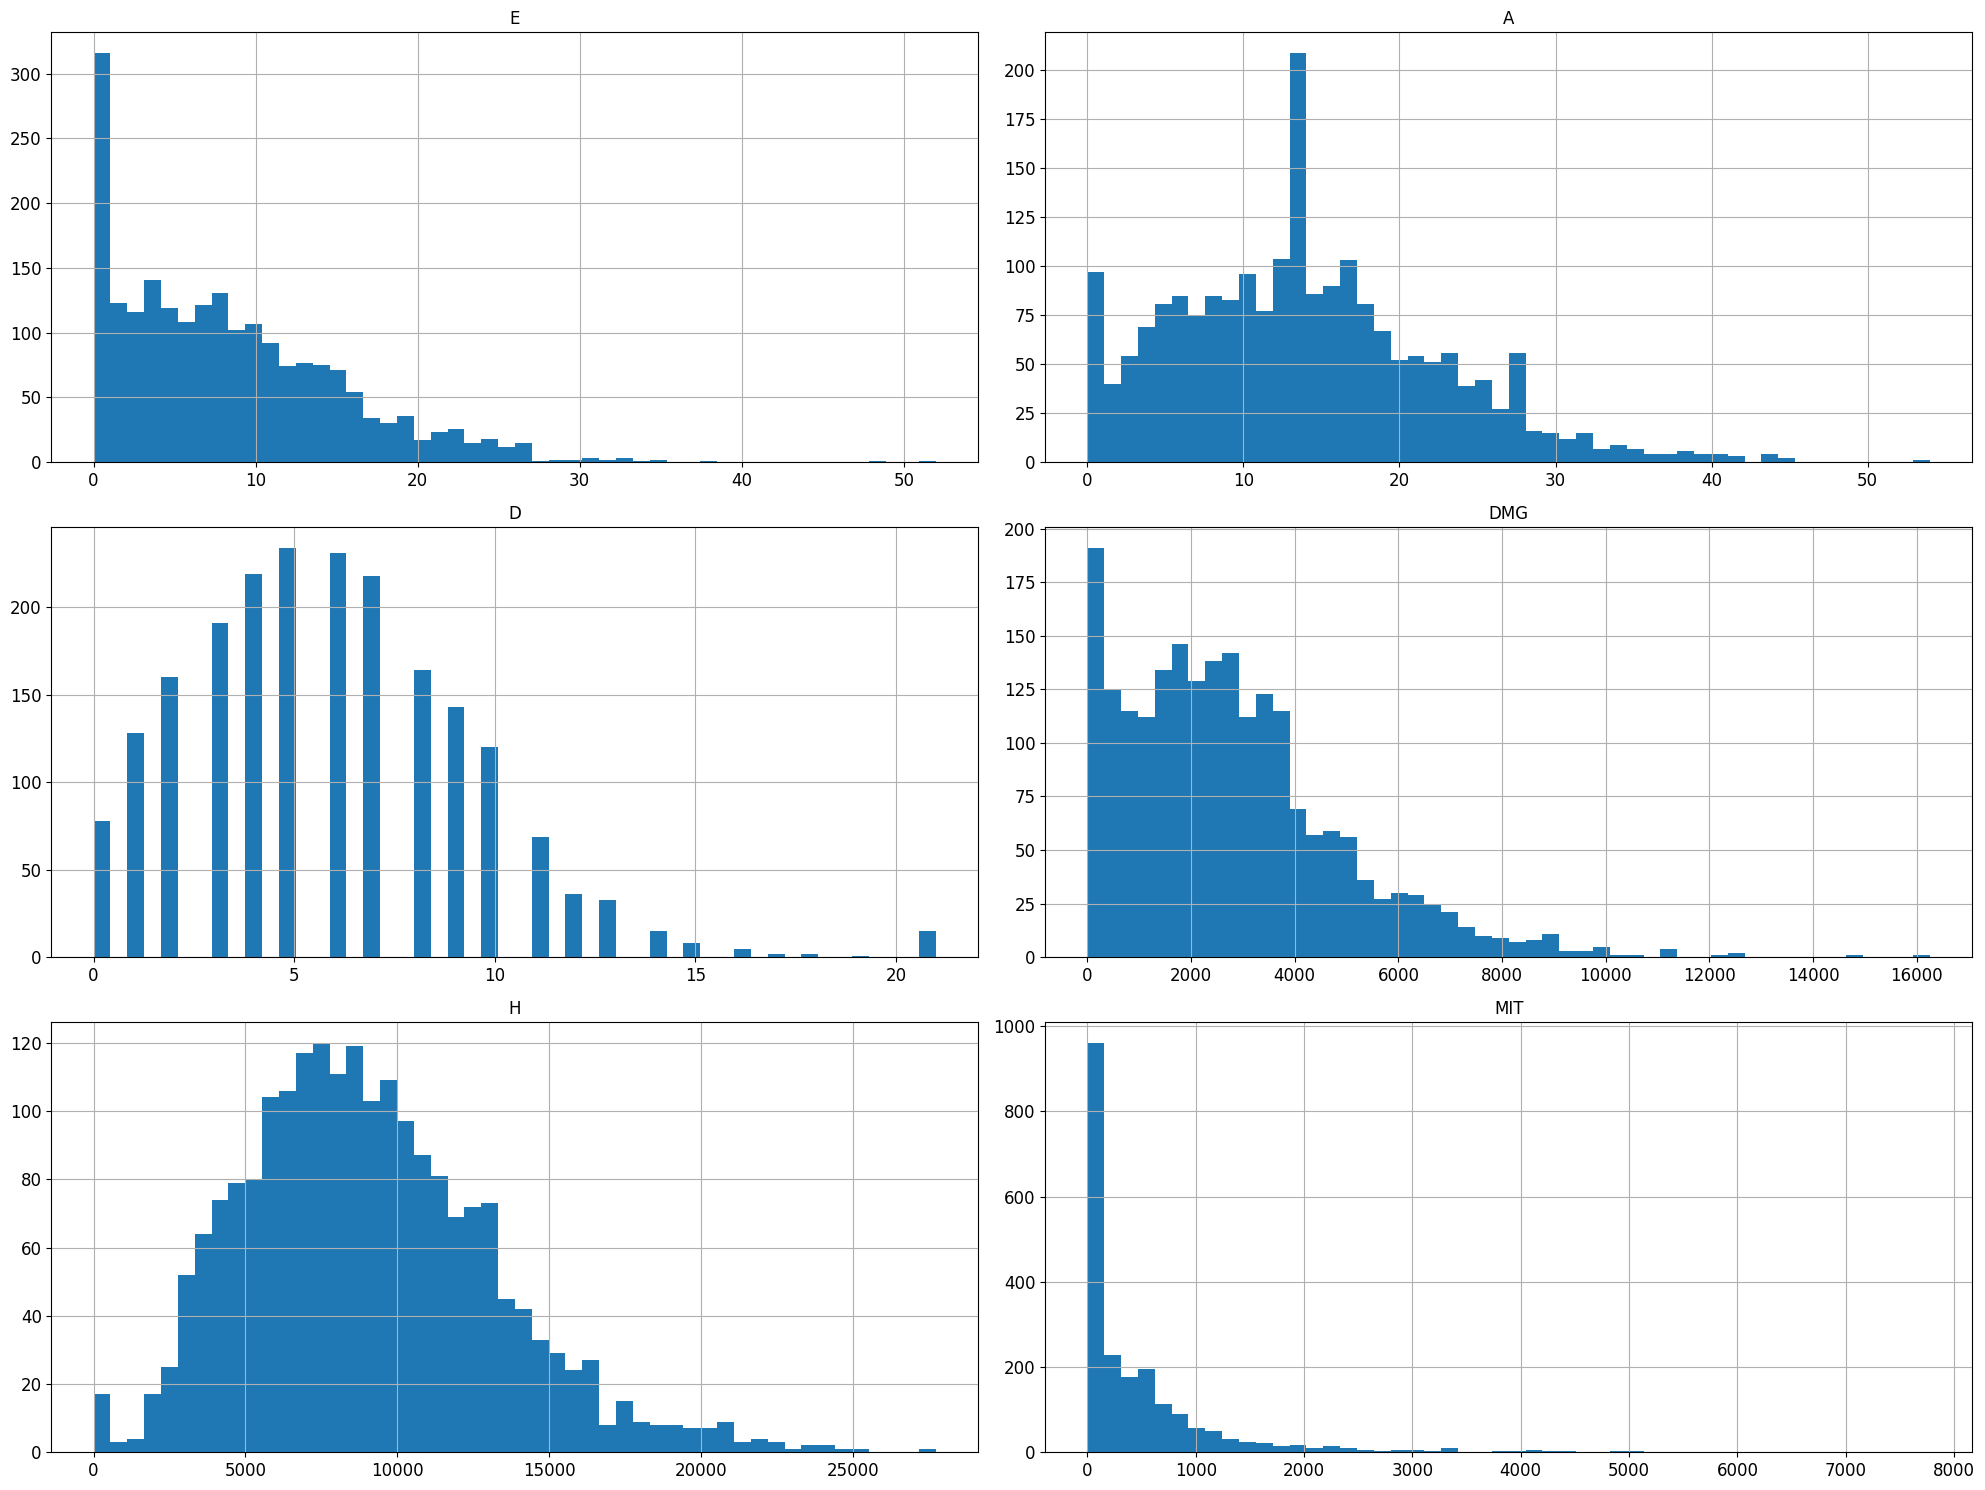

In [12]:
support.hist(bins=50, figsize=(20, 15))
save_fig('support_hist')
plt.show()

In [13]:
from sklearn import utils

scoreboards = scoreboards.loc[utils.shuffle(range(len(scoreboards.index) // players))]
scoreboards

E  A  D   DMG     H   MIT     GAME
286 0   5  0  3  4767     0  5590  VICTORY
    1  10  0  0  3435     0     0  VICTORY
    2   6  0  3  2858     0     0  VICTORY
    3   3  3  2   985  3772   471  VICTORY
    4   0  9  1     0  5592     0  VICTORY
...    .. .. ..   ...   ...   ...      ...
294 5   0  0  3  1158     0  1800   DEFEAT
    6   0  0  3  1750     0     0   DEFEAT
    7   0  0  4  1407     0   226   DEFEAT
    8   0  0  3   275  1569     0   DEFEAT
    9   0  0  3  1249  1946     0   DEFEAT

[5180 rows x 7 columns]

In [14]:
X = scoreboards.drop('GAME', axis=1)
y = scoreboards['GAME'][::players].copy()

In [15]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(X)
joblib.dump(scaler, 'scaler.joblib')
X = pd.DataFrame(scaler.transform(X), X.index, X.columns)
X

E         A         D       DMG         H       MIT
286 0  0.086207  0.000000  0.142857  0.178767  0.000000  0.133575
    1  0.172414  0.000000  0.000000  0.128816  0.000000  0.000000
    2  0.103448  0.000000  0.142857  0.107178  0.000000  0.000000
    3  0.051724  0.055556  0.095238  0.036938  0.135899  0.011255
    4  0.000000  0.166667  0.047619  0.000000  0.201470  0.000000
...         ...       ...       ...       ...       ...       ...
294 5  0.000000  0.000000  0.142857  0.043426  0.000000  0.043012
    6  0.000000  0.000000  0.142857  0.065627  0.000000  0.000000
    7  0.000000  0.000000  0.190476  0.052764  0.000000  0.005400
    8  0.000000  0.000000  0.142857  0.010313  0.056528  0.000000
    9  0.000000  0.000000  0.142857  0.046839  0.070111  0.000000

[5180 rows x 6 columns]

In [16]:
features = X.shape[-1]
total_features = players * features
X = X.values.reshape(-1, total_features)
print(X.shape)
print(y.shape)

(518, 60)
(518,)


In [17]:
from sklearn import model_selection, linear_model

cv_iter = 1600
model_selection.cross_val_score(linear_model.LogisticRegressionCV(max_iter=cv_iter), X, y)

array([0.91346154, 0.875     , 0.90384615, 0.91262136, 0.89320388])

In [18]:
from sklearn import neighbors

radius = 2.
model_selection.cross_val_score(neighbors.RadiusNeighborsClassifier(radius), X, y)

array([0.57692308, 0.53846154, 0.54807692, 0.54368932, 0.54368932])

In [19]:
from sklearn import neural_network

classifier_iter = 3200
model_selection.cross_val_score(neural_network.MLPClassifier(max_iter=classifier_iter), X, y)

array([0.89423077, 0.89423077, 0.89423077, 0.90291262, 0.89320388])

In [20]:
from sklearn import ensemble, svm, tree
import operator

estimators = (
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(n_jobs=-1),
    ensemble.ExtraTreesClassifier(n_jobs=-1),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_jobs=-1),
    ensemble.HistGradientBoostingClassifier(),
    linear_model.LogisticRegression(n_jobs=-1),
    linear_model.LogisticRegressionCV(max_iter=cv_iter, n_jobs=-1),
    linear_model.PassiveAggressiveClassifier(n_jobs=-1),
    linear_model.Perceptron(n_jobs=-1),
    linear_model.RidgeClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(n_jobs=-1),
    neighbors.KNeighborsClassifier(n_jobs=-1),
    neighbors.RadiusNeighborsClassifier(radius, n_jobs=-1),
    neighbors.NearestCentroid(),
    neural_network.MLPClassifier(max_iter=classifier_iter),
    svm.LinearSVC(dual='auto'),
    svm.NuSVC(),
    svm.SVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()
)
scores = [(estimator, model_selection.cross_val_score(estimator, X, y, n_jobs=-1).mean()) for estimator in estimators]
scores.sort(key=operator.itemgetter(1), reverse=True)
scores

[(LogisticRegression(n_jobs=-1), 0.9054144884241971),
 (RidgeClassifierCV(), 0.9034914115011203),
 (NuSVC(), 0.9015496639283047),
 (MLPClassifier(max_iter=3200), 0.8996265870052278),
 (SVC(), 0.8996265870052278),
 (LogisticRegressionCV(max_iter=1600, n_jobs=-1), 0.8996265870052277),
 (RidgeClassifier(), 0.8996265870052277),
 (NearestCentroid(), 0.8977035100821509),
 (LinearSVC(dual='auto'), 0.8938200149365197),
 (RandomForestClassifier(n_jobs=-1), 0.8880321135175503),
 (ExtraTreesClassifier(n_jobs=-1), 0.8860903659447349),
 (KNeighborsClassifier(n_jobs=-1), 0.8726661687826736),
 (GradientBoostingClassifier(), 0.8648991784914115),
 (HistGradientBoostingClassifier(), 0.862957430918596),
 (BaggingClassifier(n_jobs=-1), 0.8590365944734877),
 (SGDClassifier(n_jobs=-1), 0.8532860343539955),
 (Perceptron(n_jobs=-1), 0.8474234503360718),
 (PassiveAggressiveClassifier(n_jobs=-1), 0.843427931292009),
 (AdaBoostClassifier(), 0.8359596713965646),
 (DecisionTreeClassifier(), 0.7819268110530246),
 (

In [21]:
defeats = len(defeat) // players


def find_file(index):
    index += 1
    if index <= defeats:
        return f'DEFEAT ({index})'
    else:
        index -= len(victory) // players
        return f'VICTORY ({index})'

In [22]:
for estimator, _ in scores:
    estimator = estimator.fit(X, y)
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_.reshape(-1, features)
        tanks, damages, supports = [0, 5], [1, 2, 6, 7], [3, 4, 8, 9]
        importances_tank = importances[tanks].sum(0)
        importances_damage = importances[damages].sum(0)
        importances_support = importances[supports].sum(0)
        importances[tanks] = importances_tank / 2
        importances[damages] = importances_damage / 4
        importances[supports] = importances_support / 4
        joblib.dump(importances, 'importances.joblib')

        titles = '처치', '도움', '죽음', '피해', '치유', '경감'

        print('**특성 중요도**')
        for importance, title in sorted(zip(importances.sum(0), titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**역할 중요도**')
        for importance, title in sorted(
                zip(
                    (importances_tank.sum(), importances_damage.sum(), importances_support.sum()),
                    ('돌격(2)', '공격(4)', '지원(4)')
                ),
                reverse=True
        ):
            print(f'{title}: {importance:.3f}')

        print('\n**돌격(2) 특성 중요도**')
        for importance, title in sorted(zip(importances_tank, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**공격(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_damage, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        print('\n**지원(4) 특성 중요도**')
        for importance, title in sorted(zip(importances_support, titles), reverse=True):
            print(f'{title}: {importance:.3f}')

        break


**특성 중요도**
처치: 0.333
죽음: 0.271
도움: 0.197
피해: 0.094
경감: 0.054
치유: 0.052

**역할 중요도**
지원(4): 0.372
공격(4): 0.327
돌격(2): 0.301

**돌격(2) 특성 중요도**
죽음: 0.120
처치: 0.114
도움: 0.028
피해: 0.019
경감: 0.014
치유: 0.004

**공격(4) 특성 중요도**
처치: 0.164
죽음: 0.064
피해: 0.043
경감: 0.019
도움: 0.019
치유: 0.018

**지원(4) 특성 중요도**
도움: 0.149
죽음: 0.087
처치: 0.055
피해: 0.031
치유: 0.030
경감: 0.020


In [23]:
defeats = defeat.index.stop
for i in range(defeats - 10, defeats - 101, -players):
    defeat_i = defeat[i:i + players]
    print(f'DEFEAT ({i // players + 1})')
    print(defeat_i)
    contributions = scaler.transform(defeat_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

DEFEAT (235)
       E   A   D    DMG      H   MIT     GAME
2340  15   3  11  10458   1500  6807   DEFEAT
2341  20   1  12  10867    528   934   DEFEAT
2342  22   2  12  10057    217     0   DEFEAT
2343  11  16   3   3919   9527  4120   DEFEAT
2344   3  17   6   2152  12322   182   DEFEAT
2345  29   7   7  13062   5108  1615  VICTORY
2346  29   0   8   9443     13    13  VICTORY
2347  24   5  11  12924   1667     0  VICTORY
2348  13  20   6   2335   9931   607  VICTORY
2349  14  19   3   3554   8673     0  VICTORY
TEAM 1: 0.8 0.9 0.9 1.0 0.9
TEAM 2: 1.2 1.2 1.0 1.0 1.1

DEFEAT (234)
       E   A   D    DMG      H    MIT     GAME
2330  18   5  14  17235    708  13268   DEFEAT
2331  23   7  15  11632   1463    726   DEFEAT
2332  28   2  13  15651   1023    129   DEFEAT
2333  11  23   5   4222  11960   4298   DEFEAT
2334  11  15  13   2996  12380   1796   DEFEAT
2335  42  21   6  20623   2553   6654  VICTORY
2336  34   1  10  15022      0      0  VICTORY
2337  28  12  14   8100   1626    9

In [24]:
victorys = victory.index.stop
for i in range(victorys - 10, victorys - 101, -players):
    victory_i = victory[i:i + players]
    print(f'VICTORY ({i // players + 1})')
    print(victory_i)
    contributions = scaler.transform(victory_i.drop(['GAME'], axis=1))
    contributions[:, 2] = 1 - contributions[:, 2]
    contributions *= importances
    contributions = contributions.sum(1)
    contributions[tanks] *= 2 / contributions[tanks].sum()
    contributions[damages] *= 4 / contributions[damages].sum()
    contributions[supports] *= 4 / contributions[supports].sum()
    print(f'TEAM 1:', end='')
    for contribution in contributions[:5]:
        print(f' {contribution:.1f}', end='')
    print(f'\nTEAM 2:', end='')
    for contribution in contributions[5:]:
        print(f' {contribution:.1f}', end='')
    print('\n')

VICTORY (283)
       E   A   D   DMG     H   MIT     GAME
2820  17   3   5  5243     0  3850   DEFEAT
2821  22  10   8  5897    96     0   DEFEAT
2822  11   0   8  2828     0   113   DEFEAT
2823  11  16   2  1336  5877  2038   DEFEAT
2824  22   8   4  4741  2935     0   DEFEAT
2825   7   0   9  3772    81  5351  VICTORY
2826  14   5   8  4734     0     0  VICTORY
2827  10   0  11  5035   151   206  VICTORY
2828   6  11   7   619  5174   476  VICTORY
2829  10   0   6  4601  2056     0  VICTORY
TEAM 1: 1.2 1.3 0.9 1.3 1.1
TEAM 2: 0.8 1.0 0.8 0.9 0.7

VICTORY (282)
       E   A   D    DMG      H    MIT     GAME
2810  31   6  12  17640      0  10026   DEFEAT
2811  16   2  19   7724    305    205   DEFEAT
2812  25   7  16  10912    222   1421   DEFEAT
2813  15  20   6   5516  11431      0   DEFEAT
2814  19  29   6   6600  16221   3807   DEFEAT
2815  34  14  11  18486   1872   8270  VICTORY
2816  29   3   9  15368      0    213  VICTORY
2817  30   6  12   8374    457      0  VICTORY
2818  20

In [25]:
from tensorflow.keras import backend, layers
from tensorflow import keras

backend.clear_session()
model = keras.Sequential()
model.add(layers.Dense(300, 'relu', input_shape=(total_features,)))
model.add(layers.Dense(100, 'relu'))
model.add(layers.Dense(1, 'sigmoid'))
model.summary()

2023-12-26 08:40:29.058988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 08:40:32.393025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 08:40:32.641545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-26 08:40:32.641768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been bu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               18300     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 48501 (189.46 KB)
Trainable params: 48501 (189.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
from tensorflow.keras import optimizers, callbacks

model.compile('sgd', 'binary_crossentropy', ['accuracy'])
transform = preprocessing.LabelEncoder().fit_transform(y)
stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X,
    transform,
    epochs=256,
    callbacks=[stopping],
    validation_split=.25
)
history.history['val_loss'][-11], history.history['val_accuracy'][-11]

Epoch 1/256


2023-12-26 08:40:34.307275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-26 08:40:34.585663: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa3c8f8c2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-26 08:40:34.585696: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-12-26 08:40:34.714875: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-26 08:40:34.966632: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-26 08:40:35.147096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 2s 15ms/step - loss: 0.6787 - accuracy: 0.5567 - val_loss: 0.6688 - val_accuracy: 0.8462
Epoch 2/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6638 - accuracy: 0.8325 - val_loss: 0.6632 - val_accuracy: 0.7308
Epoch 3/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6529 - accuracy: 0.7268 - val_loss: 0.6561 - val_accuracy: 0.7615
Epoch 4/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6450 - accuracy: 0.7423 - val_loss: 0.6491 - val_accuracy: 0.7846
Epoch 5/256
13/13 [==============================] - 0s 5ms/step - loss: 0.6374 - accuracy: 0.7784 - val_loss: 0.6428 - val_accuracy: 0.7846
Epoch 6/256
13/13 [==============================] - 0s 6ms/step - loss: 0.6299 - accuracy: 0.7655 - val_loss: 0.6372 - val_accuracy: 0.7769
Epoch 7/256
13/13 [==============================] - 0s 6ms/step - loss: 0.6227 - accuracy: 0.7887 - val_loss: 0.6339 - val_accuracy: 0.7077
Epoch 8/256
13/13 [=====

(0.3168797492980957, 0.892307698726654)